In [112]:
import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.utils.data as data
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [113]:
data_transform = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.5],[0.5])
])

In [114]:
batch_size = 64
dataset = datasets.FashionMNIST('data', train = True, download = True, transform = data_transform)
data_loader = data.DataLoader(dataset, batch_size = batch_size, shuffle= True, num_workers = 4, pin_memory = True)
print(f'Number of images: {len(dataset)}')

Number of images: 60000


In [115]:
classes = dataset.classes
num_classes = len(classes)
print(classes)
print(num_classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
10


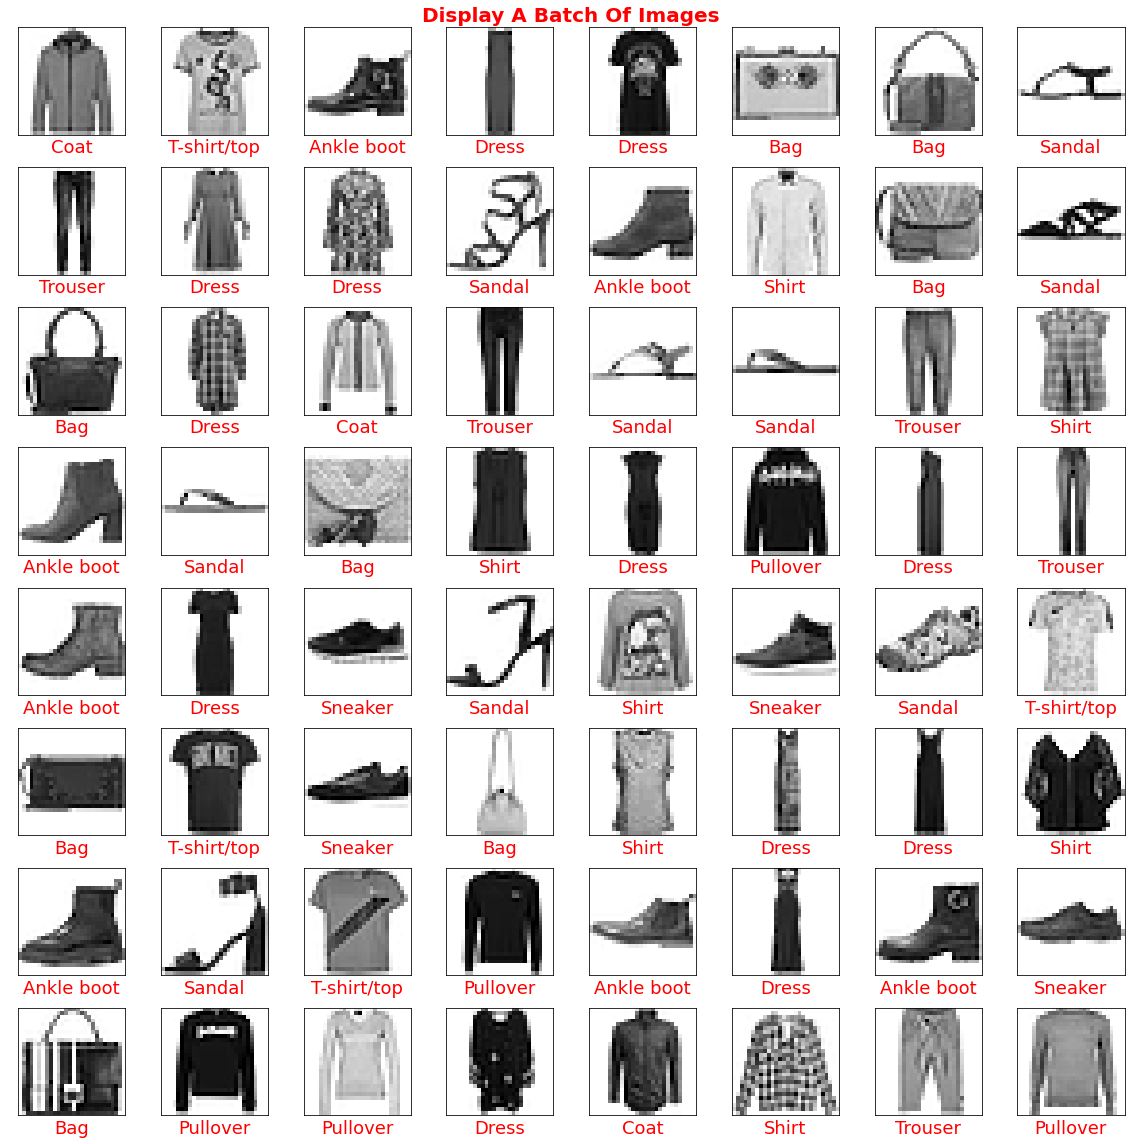

In [116]:
def visualize_images(data_loader):
    fig = plt.figure(figsize = (16, 16))
    plt.axis('off')
    plt.title('Display A Batch Of Images', color = 'red', fontsize = 20, fontweight = 'bold')
    images, labels = next(iter(data_loader))

    for id, (image, label) in enumerate(zip(images, labels)):
        fig.add_subplot(8, 8, id + 1)
        image = image.numpy().transpose((1, 2, 0))
        image = image.squeeze()
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image, cmap = 'gray_r')
        # plt.imshow(image)
        plt.xlabel(classes[label], color = 'red', fontsize = 18)
    
    plt.tight_layout()
    plt.show()

visualize_images(data_loader)


In [127]:
def generate_labels(size, label):
    if label:
        result = torch.ones(size) - 0.1
    else:
        result = torch.zeros(size)
    
    return Variable(result).view(-1).to(device)

In [128]:
def generate_random_classes(size):
    data = torch.LongTensor(np.random.randint(0, 1, size))
    return Variable(data).to(device)

In [129]:
# Create random noise base on gaussian init
def random_noise(size):
    noise = torch.randn(size, 100)
    return Variable(noise).to(device)

In [130]:
class Generator(nn.Module):
    def __init__(self, input, output):
        super(Generator, self).__init__()
        self.label_embed = nn.Embedding(10, 10)

        self.linear = nn.Sequential(
            nn.Linear(input + 10, 256), # Because we have concat with label (size = 10) so must + 10
            nn.LeakyReLU(0.2, inplace  = True),

            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace = True),

            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace = True),

            nn.Linear(1024, output),
            nn.Tanh()
        )
    
    def forward(self, x, y):
        x = x.view(-1, 100)
        y = self.label_embed(y)
        x = torch.cat([x,y], 1)
        x = self.linear(x)

        return x.view(-1, 28, 28)


In [131]:
class Discriminator(nn.Module):
    def __init__(self, input, output):
        super(Discriminator, self).__init__()
        self.label_embed = nn.Embedding(10, 10)

        self.linear = nn.Sequential(
            nn.Linear(input + 10, 1024),
            nn.LeakyReLU(0.2, inplace = True),

            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Dropout(0.3),

            nn.Linear(256, output),
            nn.Sigmoid()
        )

    def forward(self, x, y):
        y = self.label_embed(y)
        x = x.view(-1, 28 * 28)
        x = torch.cat([x,y], 1)
        x = self.linear(x)

        return x.squeeze()


In [132]:
G = Generator(100, 28*28).to(device)
D = Discriminator(28*28, 1).to(device)

criterion = nn.BCELoss()
G_optimizer = torch.optim.Adam(G.parameters(), lr = 1e-04)
D_optimizer = torch.optim.Adam(D.parameters(), lr = 1e-04)


In [133]:
def train_generator_step(G, D, G_optimizer, criterion, real_batch):
    batch_size = real_batch.size(0)
    G_optimizer.zero_grad()

    fake_classes = generate_random_classes(batch_size)
    fake_data = G(random_noise(batch_size), fake_classes).to(device)

    pred = D(fake_data, fake_classes)

    label = generate_labels(batch_size, 1)
    loss = criterion(pred, label)
    loss.backward()

    D_g_z2 = pred.mean().item()

    G_optimizer.step()
    return loss.data, D_g_z2

In [134]:
def train_discriminator_step(G, D, criterion, D_optimizer, real_batch, real_classes_size):
    batch_size = real_batch.size(0)
    D_optimizer.zero_grad()

    real_classes = Variable(real_classes_size.to(device))
    real_data = Variable(real_batch.view(-1, 28 * 28)).to(device)
    real_pred = D(real_data, real_classes)
    
    real_label = generate_labels(batch_size, 1)
    real_loss = criterion(real_pred, real_label)

    fake_classes = generate_random_classes(batch_size)
    fake_data = G(random_noise(batch_size), fake_classes).detach().to(device)
    fake_pred = D(fake_data, fake_classes)

    fake_label = generate_labels(batch_size, 0)
    fake_loss = criterion(fake_pred, fake_label)

    loss = fake_loss + real_loss
    loss.backward()

    D_x = real_pred.mean().item()
    D_g_z1 = fake_pred.mean().item()

    D_optimizer.step()

    return real_loss.data + fake_loss.data, D_x, D_g_z1

In [135]:
# Plot 10 pics
noise = random_noise(10)
def plot_train_images(G, noise):
    G.eval()

    fig = plt.figure(figsize = (10, 5))
    plt.title('Generated Images')
    plt.axis('off')
    
    with torch.no_grad():
        labels = torch.LongTensor([i for i in range(10)]).to(device)
        img = G(noise, labels).cpu().numpy()
        for id, image in enumerate(img):
            fig.add_subplot(2, 5, id + 1)
            plt.axis('off')
            plt.imshow(image, cmap = 'gray_r')

    plt.tight_layout()
    plt.show()

    G.train()

In [138]:
num_epochs = 100
def train(G, D, G_optimizer, D_optimizer, criterion, data_loader):
    G_loss_list = []
    D_loss_list = []
    print('------------- Start Training -----------!')
    for epoch in range(num_epochs):
        for i, (real_batch, real_classes_size) in enumerate(data_loader):
            G_loss, D_g_z2 = train_generator_step(G,D,G_optimizer,criterion,real_batch)
            D_loss, D_x, D_g_z1 = train_discriminator_step(G, D, criterion, D_optimizer, real_batch, real_classes_size)

            if i == len(data_loader)//2 or i == len(data_loader) - 1:
                print("Epoch: ({}/{}), Batch: ({}/{}), D_Loss: {:.4f}, G_Loss: {:.4f}, D(x): {:.4f}, G(D(z)): {:.4f} / {:.4f}".format(epoch+1, num_epochs, i+1, len(data_loader),
                                                                                                                                      D_loss, G_loss, D_x, D_g_z1, D_g_z2))
                D_loss_list.append(D_loss)
                G_loss_list.append(G_loss)
            
        if epoch % 10 == 0:
            torch.save(G.state_dict(), f'drive/My Drive/GAN/cGAN/model/generator/generator_{epoch}')
            torch.save(D.state_dict(), f'drive/My Drive/GAN/cGAN/model/discriminator/discriminator_{epoch}')

            plot_train_images(G, noise)
    print('------------- Done Training ------------!')
    return G, D_loss_list, G_loss_list

------------- Start Training -----------!
Epoch: (1/80), Batch: (470/938), D_Loss: 0.3539, G_Loss: 6.2262, D(x): 0.8804, G(D(z)): 0.0048 / 0.0014
Epoch: (1/80), Batch: (938/938), D_Loss: 0.5956, G_Loss: 6.7701, D(x): 0.8625, G(D(z)): 0.0028 / 0.0018


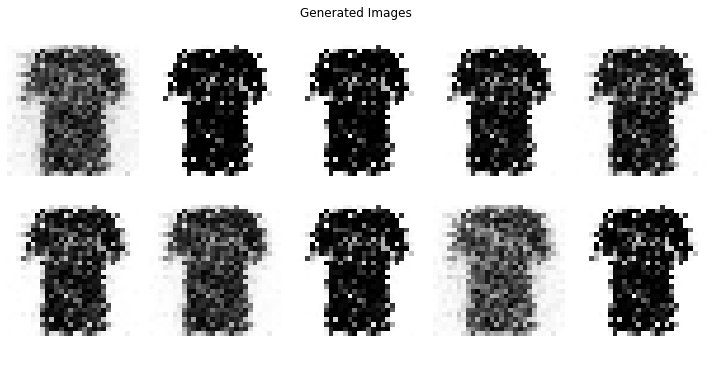

Epoch: (2/80), Batch: (470/938), D_Loss: 0.4093, G_Loss: 5.3960, D(x): 0.8719, G(D(z)): 0.0190 / 0.0088
Epoch: (2/80), Batch: (938/938), D_Loss: 0.3342, G_Loss: 7.8735, D(x): 0.8801, G(D(z)): 0.0008 / 0.0003
Epoch: (3/80), Batch: (470/938), D_Loss: 0.3625, G_Loss: 4.3836, D(x): 0.8903, G(D(z)): 0.0239 / 0.0129
Epoch: (3/80), Batch: (938/938), D_Loss: 0.5734, G_Loss: 5.6500, D(x): 0.8188, G(D(z)): 0.0131 / 0.0038
Epoch: (4/80), Batch: (470/938), D_Loss: 0.3816, G_Loss: 5.4055, D(x): 0.8529, G(D(z)): 0.0110 / 0.0057
Epoch: (4/80), Batch: (938/938), D_Loss: 0.4201, G_Loss: 4.6555, D(x): 0.8523, G(D(z)): 0.0256 / 0.0173
Epoch: (5/80), Batch: (470/938), D_Loss: 0.5601, G_Loss: 5.2081, D(x): 0.8372, G(D(z)): 0.0347 / 0.0085
Epoch: (5/80), Batch: (938/938), D_Loss: 0.3714, G_Loss: 5.4557, D(x): 0.8719, G(D(z)): 0.0106 / 0.0048
Epoch: (6/80), Batch: (470/938), D_Loss: 0.4776, G_Loss: 2.6765, D(x): 0.8837, G(D(z)): 0.1135 / 0.0754
Epoch: (6/80), Batch: (938/938), D_Loss: 0.3612, G_Loss: 4.1570,

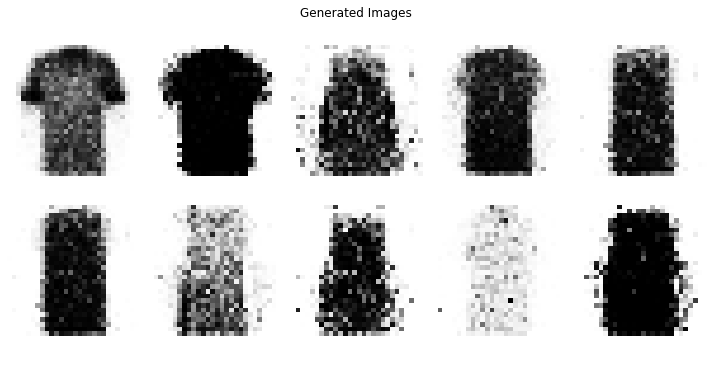

Epoch: (12/80), Batch: (470/938), D_Loss: 0.6525, G_Loss: 2.7679, D(x): 0.8135, G(D(z)): 0.0941 / 0.0580
Epoch: (12/80), Batch: (938/938), D_Loss: 0.5396, G_Loss: 4.2327, D(x): 0.8186, G(D(z)): 0.0265 / 0.0152
Epoch: (13/80), Batch: (470/938), D_Loss: 0.4294, G_Loss: 3.1284, D(x): 0.8657, G(D(z)): 0.0511 / 0.0406
Epoch: (13/80), Batch: (938/938), D_Loss: 0.5391, G_Loss: 2.4503, D(x): 0.8406, G(D(z)): 0.1121 / 0.0781
Epoch: (14/80), Batch: (470/938), D_Loss: 0.5162, G_Loss: 2.4820, D(x): 0.8518, G(D(z)): 0.0814 / 0.0765
Epoch: (14/80), Batch: (938/938), D_Loss: 0.5910, G_Loss: 2.9933, D(x): 0.8028, G(D(z)): 0.0583 / 0.0504
Epoch: (15/80), Batch: (470/938), D_Loss: 0.4903, G_Loss: 3.2993, D(x): 0.8479, G(D(z)): 0.0459 / 0.0327
Epoch: (15/80), Batch: (938/938), D_Loss: 0.4477, G_Loss: 2.3675, D(x): 0.8832, G(D(z)): 0.0840 / 0.0888
Epoch: (16/80), Batch: (470/938), D_Loss: 0.4252, G_Loss: 3.1111, D(x): 0.8716, G(D(z)): 0.0486 / 0.0461
Epoch: (16/80), Batch: (938/938), D_Loss: 0.5247, G_Los

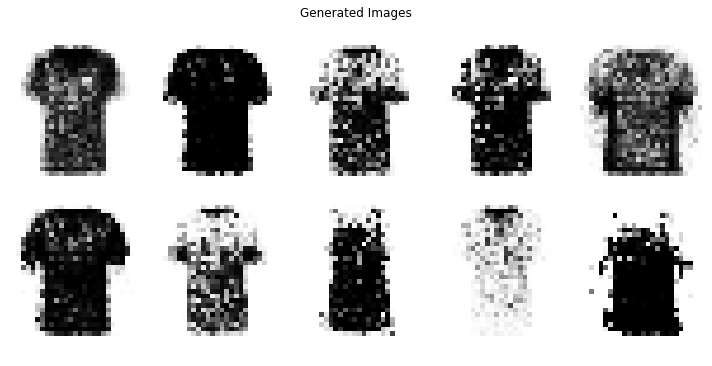

Epoch: (22/80), Batch: (470/938), D_Loss: 0.7510, G_Loss: 2.5717, D(x): 0.7530, G(D(z)): 0.0898 / 0.0793
Epoch: (22/80), Batch: (938/938), D_Loss: 0.9144, G_Loss: 2.6332, D(x): 0.7230, G(D(z)): 0.0694 / 0.0658
Epoch: (23/80), Batch: (470/938), D_Loss: 0.4708, G_Loss: 2.8165, D(x): 0.8507, G(D(z)): 0.0829 / 0.0596
Epoch: (23/80), Batch: (938/938), D_Loss: 0.4458, G_Loss: 2.8602, D(x): 0.8838, G(D(z)): 0.0568 / 0.0470
Epoch: (24/80), Batch: (470/938), D_Loss: 0.5335, G_Loss: 3.0626, D(x): 0.8362, G(D(z)): 0.0563 / 0.0512
Epoch: (24/80), Batch: (938/938), D_Loss: 0.6370, G_Loss: 2.8689, D(x): 0.7768, G(D(z)): 0.0648 / 0.0545
Epoch: (25/80), Batch: (470/938), D_Loss: 0.6524, G_Loss: 3.1895, D(x): 0.7877, G(D(z)): 0.0413 / 0.0399
Epoch: (25/80), Batch: (938/938), D_Loss: 0.7065, G_Loss: 2.1396, D(x): 0.7779, G(D(z)): 0.1231 / 0.1011
Epoch: (26/80), Batch: (470/938), D_Loss: 0.5867, G_Loss: 3.0371, D(x): 0.7939, G(D(z)): 0.0372 / 0.0473
Epoch: (26/80), Batch: (938/938), D_Loss: 0.5232, G_Los

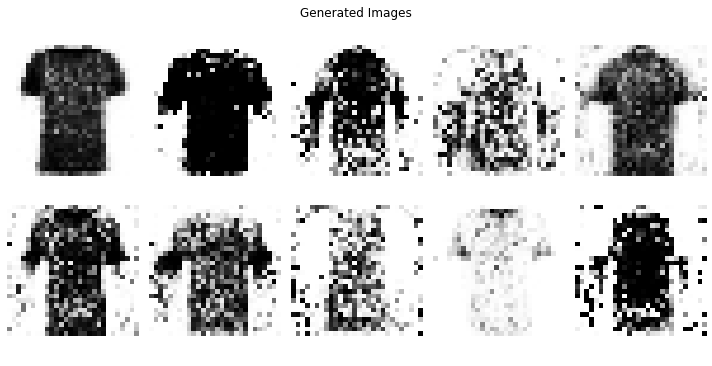

Epoch: (32/80), Batch: (470/938), D_Loss: 0.6606, G_Loss: 2.6560, D(x): 0.7741, G(D(z)): 0.0518 / 0.0581
Epoch: (32/80), Batch: (938/938), D_Loss: 0.5669, G_Loss: 2.5929, D(x): 0.8285, G(D(z)): 0.0573 / 0.0622
Epoch: (33/80), Batch: (470/938), D_Loss: 0.5837, G_Loss: 2.7919, D(x): 0.8318, G(D(z)): 0.0621 / 0.0589
Epoch: (33/80), Batch: (938/938), D_Loss: 0.5803, G_Loss: 2.2142, D(x): 0.8275, G(D(z)): 0.0925 / 0.0983
Epoch: (34/80), Batch: (470/938), D_Loss: 0.5151, G_Loss: 2.4406, D(x): 0.8545, G(D(z)): 0.0891 / 0.0768
Epoch: (34/80), Batch: (938/938), D_Loss: 0.6543, G_Loss: 2.3760, D(x): 0.8190, G(D(z)): 0.0866 / 0.0774
Epoch: (35/80), Batch: (470/938), D_Loss: 0.5259, G_Loss: 3.2468, D(x): 0.8388, G(D(z)): 0.0325 / 0.0317
Epoch: (35/80), Batch: (938/938), D_Loss: 0.4329, G_Loss: 2.6695, D(x): 0.9017, G(D(z)): 0.0973 / 0.0579
Epoch: (36/80), Batch: (470/938), D_Loss: 0.4897, G_Loss: 2.5685, D(x): 0.8657, G(D(z)): 0.0897 / 0.0714
Epoch: (36/80), Batch: (938/938), D_Loss: 0.5101, G_Los

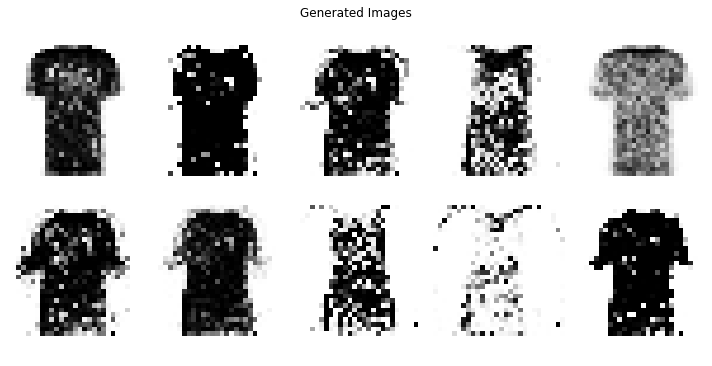

Epoch: (42/80), Batch: (470/938), D_Loss: 0.6739, G_Loss: 3.1458, D(x): 0.7817, G(D(z)): 0.0530 / 0.0381
Epoch: (42/80), Batch: (938/938), D_Loss: 0.5899, G_Loss: 2.4956, D(x): 0.8365, G(D(z)): 0.1032 / 0.0722
Epoch: (43/80), Batch: (470/938), D_Loss: 0.4906, G_Loss: 2.5349, D(x): 0.8715, G(D(z)): 0.0886 / 0.0743
Epoch: (43/80), Batch: (938/938), D_Loss: 0.5958, G_Loss: 2.6106, D(x): 0.8299, G(D(z)): 0.0659 / 0.0609
Epoch: (44/80), Batch: (470/938), D_Loss: 0.5629, G_Loss: 2.1912, D(x): 0.8344, G(D(z)): 0.1047 / 0.1003
Epoch: (44/80), Batch: (938/938), D_Loss: 0.6349, G_Loss: 2.4882, D(x): 0.7979, G(D(z)): 0.0944 / 0.0840
Epoch: (45/80), Batch: (470/938), D_Loss: 0.6200, G_Loss: 2.4552, D(x): 0.8139, G(D(z)): 0.0957 / 0.0821
Epoch: (45/80), Batch: (938/938), D_Loss: 0.6559, G_Loss: 2.8840, D(x): 0.7708, G(D(z)): 0.0670 / 0.0555
Epoch: (46/80), Batch: (470/938), D_Loss: 0.5650, G_Loss: 2.9906, D(x): 0.8193, G(D(z)): 0.0520 / 0.0483
Epoch: (46/80), Batch: (938/938), D_Loss: 0.6612, G_Los

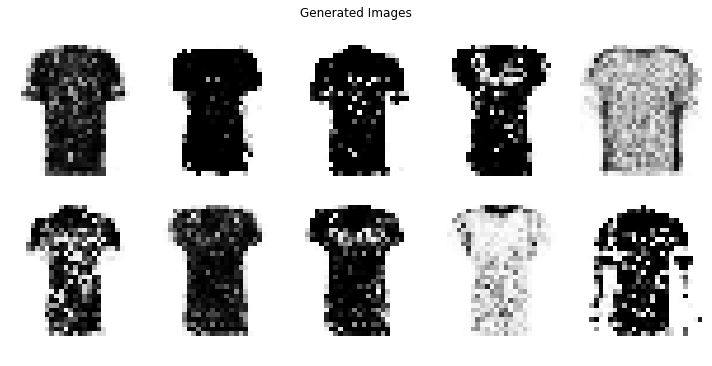

Epoch: (52/80), Batch: (470/938), D_Loss: 0.7830, G_Loss: 2.7093, D(x): 0.7695, G(D(z)): 0.1059 / 0.0657
Epoch: (52/80), Batch: (938/938), D_Loss: 0.7053, G_Loss: 2.7226, D(x): 0.7554, G(D(z)): 0.0587 / 0.0522
Epoch: (53/80), Batch: (470/938), D_Loss: 0.5429, G_Loss: 2.4255, D(x): 0.8402, G(D(z)): 0.0764 / 0.0725
Epoch: (53/80), Batch: (938/938), D_Loss: 0.6114, G_Loss: 2.7661, D(x): 0.8087, G(D(z)): 0.0677 / 0.0538
Epoch: (54/80), Batch: (470/938), D_Loss: 0.5187, G_Loss: 3.0250, D(x): 0.8416, G(D(z)): 0.0475 / 0.0418
Epoch: (54/80), Batch: (938/938), D_Loss: 0.5245, G_Loss: 2.3951, D(x): 0.8574, G(D(z)): 0.0756 / 0.0756
Epoch: (55/80), Batch: (470/938), D_Loss: 0.4723, G_Loss: 2.9650, D(x): 0.8464, G(D(z)): 0.0525 / 0.0435
Epoch: (55/80), Batch: (938/938), D_Loss: 0.6117, G_Loss: 2.5600, D(x): 0.8316, G(D(z)): 0.0845 / 0.0618
Epoch: (56/80), Batch: (470/938), D_Loss: 0.6176, G_Loss: 2.5596, D(x): 0.7916, G(D(z)): 0.0624 / 0.0688
Epoch: (56/80), Batch: (938/938), D_Loss: 0.5276, G_Los

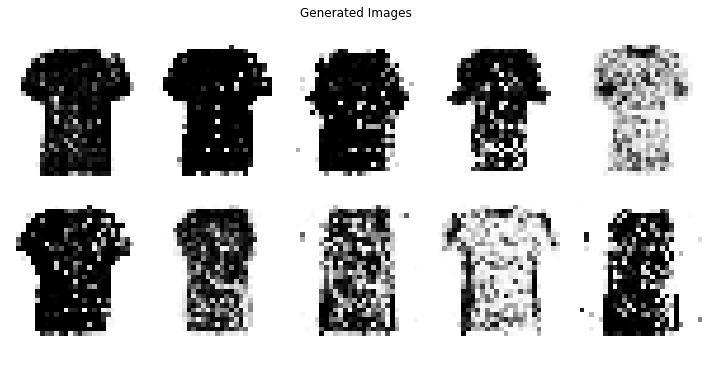

Epoch: (62/80), Batch: (470/938), D_Loss: 0.6902, G_Loss: 2.6289, D(x): 0.7617, G(D(z)): 0.0639 / 0.0613
Epoch: (62/80), Batch: (938/938), D_Loss: 0.5334, G_Loss: 3.0039, D(x): 0.8514, G(D(z)): 0.0893 / 0.0463
Epoch: (63/80), Batch: (470/938), D_Loss: 0.5807, G_Loss: 2.5051, D(x): 0.8162, G(D(z)): 0.0784 / 0.0739
Epoch: (63/80), Batch: (938/938), D_Loss: 0.4835, G_Loss: 2.4419, D(x): 0.8812, G(D(z)): 0.0762 / 0.0742
Epoch: (64/80), Batch: (470/938), D_Loss: 0.6520, G_Loss: 3.3994, D(x): 0.7842, G(D(z)): 0.0415 / 0.0319
Epoch: (64/80), Batch: (938/938), D_Loss: 0.5501, G_Loss: 2.6506, D(x): 0.8503, G(D(z)): 0.0550 / 0.0588
Epoch: (65/80), Batch: (470/938), D_Loss: 0.4608, G_Loss: 2.7917, D(x): 0.8742, G(D(z)): 0.0654 / 0.0538
Epoch: (65/80), Batch: (938/938), D_Loss: 0.4457, G_Loss: 2.1842, D(x): 0.8813, G(D(z)): 0.0820 / 0.0989
Epoch: (66/80), Batch: (470/938), D_Loss: 0.6877, G_Loss: 2.1898, D(x): 0.7833, G(D(z)): 0.0977 / 0.0968
Epoch: (66/80), Batch: (938/938), D_Loss: 0.5224, G_Los

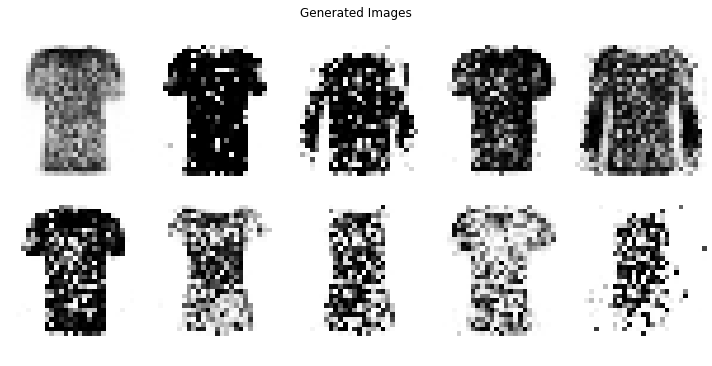

Epoch: (72/80), Batch: (470/938), D_Loss: 0.5881, G_Loss: 2.1735, D(x): 0.8110, G(D(z)): 0.0861 / 0.0995
Epoch: (72/80), Batch: (938/938), D_Loss: 0.5206, G_Loss: 2.8790, D(x): 0.8583, G(D(z)): 0.0525 / 0.0482
Epoch: (73/80), Batch: (470/938), D_Loss: 0.5057, G_Loss: 2.4309, D(x): 0.8704, G(D(z)): 0.0809 / 0.0777
Epoch: (73/80), Batch: (938/938), D_Loss: 0.6581, G_Loss: 2.6207, D(x): 0.8166, G(D(z)): 0.0795 / 0.0630
Epoch: (74/80), Batch: (470/938), D_Loss: 0.5575, G_Loss: 2.5764, D(x): 0.8271, G(D(z)): 0.0750 / 0.0658
Epoch: (74/80), Batch: (938/938), D_Loss: 0.5189, G_Loss: 2.3340, D(x): 0.8437, G(D(z)): 0.0710 / 0.0819
Epoch: (75/80), Batch: (470/938), D_Loss: 0.8084, G_Loss: 2.8243, D(x): 0.7642, G(D(z)): 0.0598 / 0.0504
Epoch: (75/80), Batch: (938/938), D_Loss: 0.8270, G_Loss: 1.9788, D(x): 0.7338, G(D(z)): 0.1133 / 0.1182
Epoch: (76/80), Batch: (470/938), D_Loss: 0.5297, G_Loss: 2.4203, D(x): 0.8524, G(D(z)): 0.0886 / 0.0758
Epoch: (76/80), Batch: (938/938), D_Loss: 0.5892, G_Los

In [139]:
generator, D_loss_list, G_loss_list = train(G, D, G_optimizer, D_optimizer, criterion, data_loader)

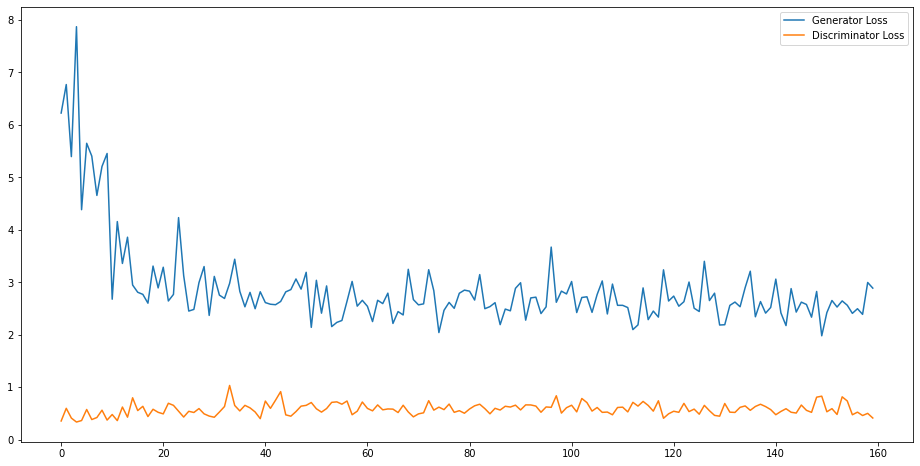

In [141]:
def plot_curves(G_loss_list, D_loss_list):
    fig = plt.figure(figsize = (16, 8))
    plt.plot(range(len(G_loss_list)), G_loss_list, label = 'Generator Loss')
    plt.plot(range(len(D_loss_list)), D_loss_list, label = 'Discriminator Loss')
    plt.legend()
    plt.show()
plot_curves(G_loss_list, D_loss_list)

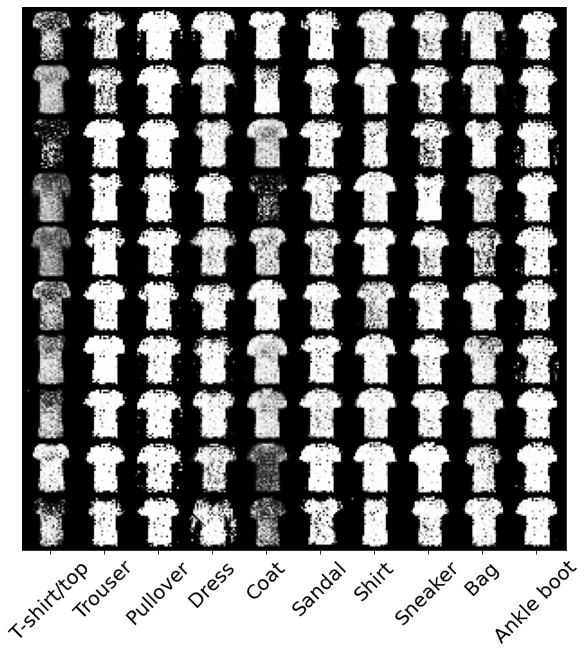

In [143]:
z = Variable(torch.randn(100, 100)).to(device)
labels = torch.LongTensor([i for _ in range(10) for i in range(10)]).to(device)
images = G(z, labels).unsqueeze(1).cpu()
grid = torchvision.utils.make_grid(images, nrow=10,normalize= True)
fig, ax = plt.subplots(figsize = (10, 10))
ax.imshow(grid.permute(1, 2, 0).data, cmap ='binary')
_ = plt.yticks([])
_ = plt.xticks(np.arange(15, 300, 30), classes, rotation=45, fontsize=20)

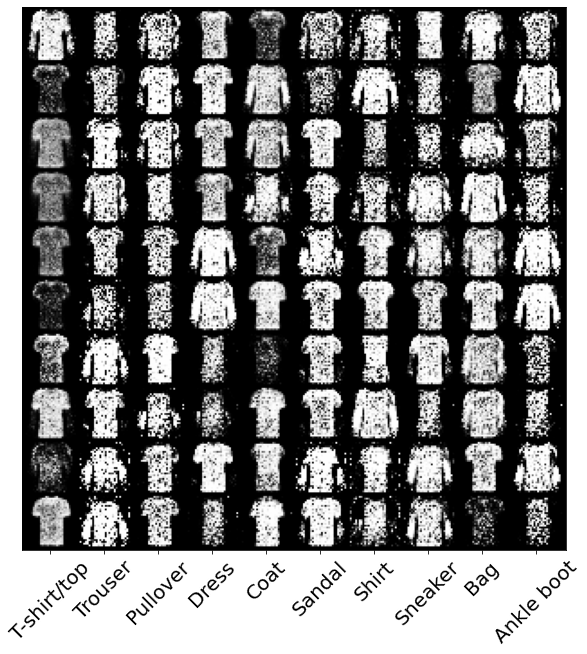

In [144]:
generator.load_state_dict(torch.load('drive/My Drive/GAN/cGAN/model/generator/generator_71'))
z = Variable(torch.randn(100, 100)).to(device)
labels = torch.LongTensor([i for _ in range(10) for i in range(10)]).to(device)
images = G(z, labels).unsqueeze(1).cpu()
grid = torchvision.utils.make_grid(images, nrow=10,normalize= True)
fig, ax = plt.subplots(figsize = (10, 10))
ax.imshow(grid.permute(1, 2, 0).data, cmap ='binary')
_ = plt.yticks([])
_ = plt.xticks(np.arange(15, 300, 30), classes, rotation=45, fontsize=20)